<font size=10>Assignment 4

<font size=8>Introduction

<font size=4> Objective: Develop a comprehensive model of the Co-Zr-Cr-Ti quaternary system and assess its glass-forming capabilities through the utilization of Maximum Full Width at Half Maximum (MaxFWHM) measurements. The investigation will involve a thorough exploration of pertinent features, employing sophisticated featurization techniques, and implementing cross-validation methodologies to enhance the model's predictability in accordance with physical measurements.

<font size=8>Code

<font size=6>Modules

In [3]:
#Loading dependencies
import scipy.io
import numpy.matlib as nm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pymatgen
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)#stack overflow "https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning"
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")


In [4]:
#Versions used
print(pd.__version__) #2.2.0
print(np.__version__) #1.26.4
print(scipy.__version__) #1.12.0
print(sklearn.__version__) #1.2.1
print(pymatgen.__version__) #2024.2.8

2.2.0
1.26.4
1.12.0
1.4.1.post1


AttributeError: module 'pymatgen' has no attribute '__version__'

<font size=6>Importing data

In [ ]:
# Load data from the same CSV file with different sheets
xls_file = pd.ExcelFile('Metallic Glass Data.xlsx')  # Update with your actual file name

# Read data from different sheets
CrTiZr_data = xls_file.parse('CrTiZr')
CrCoZr_data = xls_file.parse('CrCoZr')
CoTiZr_data = xls_file.parse('CoTiZr')

#add a string of the elements in the compound
CrTiZr_data['comp_string'] = 'CrTiZr'
CrCoZr_data['comp_string'] = 'CrCoZr'
CoTiZr_data['comp_string'] = 'CoTiZr'

#creating an element map
element_map = {'Co': 'CrTiZr',
               'Ti': 'CrCoZr',
               'Cr': 'CoTiZr'}

In [ ]:
#using function given in Practical #5 for plotting ternary diagrams

import ternary

def plot_ternary(data, components, z, label, title=''):
    
    fig, ax = plt.subplots()
    scale = 100

    grid = plt.GridSpec(10, 10, wspace=2, hspace=1)
    ax = plt.subplot(grid[:,:9])

    figure, tax = ternary.figure(scale=scale, ax=ax)
    # Draw Boundary and Gridlines
    tax.boundary(linewidth=2.0)
    tax.gridlines(color="red", multiple=10)

    # Set Axis labels and Title
    fontsize = 12
    offset = 0.14
    tax.right_corner_label(components[0], fontsize=fontsize, offset=0.2, fontweight='bold')
    tax.top_corner_label(components[2], fontsize=fontsize, offset=0.23, fontweight='bold')
    tax.left_corner_label(components[1], fontsize=fontsize, offset=0.2, fontweight='bold')
    tax.left_axis_label("at.%", fontsize=fontsize, offset=offset)
    tax.right_axis_label("at.%", fontsize=fontsize, offset=offset)
    tax.bottom_axis_label("at.%", fontsize=fontsize, offset=offset)
    tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025, clockwise= True)
    tax.get_axes().axis('off')
    tax.clear_matplotlib_ticks()

    
    
    # Create color map and plot color bar
    cmap = plt.cm.plasma
    norm = plt.Normalize(0, z.max())
    
    tax.scatter(data, marker='o', c=cmap(norm(z)), edgecolors='k', alpha=1, s=30, vmin=z.min(), vmax=z.max())
    
    ax = plt.subplot(grid[1:-1,9:])
    cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical', label=label)
    cb1.set_label(label=label, size=18)
    fig.suptitle(title,y=1,weight='bold')

Ternary system exploration

In [ ]:
# Merge the ternary systems to create the quaternary system dataset

# a = cr , b = co , c =ti , d = zr
components = ['Cr','Co','Ti','Zr']
CoTiZr_components = [components[i] for i in [1,2,3]]
CrCoZr_components = [components[i] for i in [0,1,3]]
CrTiZr_components = [components[i] for i in [0,2,3]]

component_list = [CrTiZr_components,CrCoZr_components,CoTiZr_components]
data = [CrTiZr_data,CrCoZr_data,CoTiZr_data]

for c,d in zip(component_list,data):
    cmp =d.loc[:,c].to_numpy()
    cmp*=100
    points=nm.vstack((cmp[:,0].T,cmp[:,2].T)).T

    #plot_ternary(points, c, d['MaxFWHM'], label='FWHM $\AA^{-1}$',title= f'{c}')

Bridge - Creating a quaternary dataframe

In [ ]:
temp= pd.concat([CrTiZr_data.pop('MaxFWHM'), CrCoZr_data.pop('MaxFWHM'), CoTiZr_data.pop('MaxFWHM')],ignore_index=True)
quaternary_data = pd.merge(CrTiZr_data,CrCoZr_data,on=['Cr', 'Zr','comp_string'],how='outer')
quaternary_data = pd.merge(quaternary_data, CoTiZr_data, on=['Co', 'Ti', 'Zr','comp_string'],how='outer')
quaternary_data=pd.concat([quaternary_data,temp],axis=1)

Filling NaN values

In [ ]:
#NanN values appear where element is missing, so 0 is a valid replacement
quaternary_data.fillna(0,inplace=True)

In [ ]:
quaternary_data

<font size=6>Featurize

Getting a matpygem composition value

In [ ]:
#Conversion code modiffied from GPT 3.5 template
import pandas as pd
from pymatgen import core

# Apply the featurizer to each row of the DataFrame
compositions = []
for index, row in quaternary_data[components].iterrows():
    # Convert the row (elemental fractions) to a dictionary
    element_fractions = row.to_dict()
     # Convert the elemental fractions to a Pymatgen Composition object
    composition = core.Composition(element_fractions)
    # Append the features to the result list
    compositions.append(composition)
# Convert the result features list to a new DataFrame
compositions_df = pd.DataFrame(pd.Series(compositions,name='composition'))
quaternary_data_with_composition = pd.concat([quaternary_data, compositions_df],axis=1)


In [ ]:
quaternary_data_with_composition

featurzing with magpie

In [ ]:
#Template modified from lecture 5 slides

from matminer.featurizers.composition import composite as comp

features = [ "Number", "MendeleevNumber", "AtomicWeight", "MeltingT",  "Column", "Row", "CovalentRadius", "Electronegativity", "NsValence", "NpValence", "NdValence", "NfValence", "NValence", "NsUnfilled", "NpUnfilled", "NdUnfilled", "NfUnfilled", "NUnfilled","GSvolume_pa", "GSbandgap", "GSmagmom"]
stats = ["mean", "avg_dev", "minimum", "maximum", "range"]
magpie = comp.ElementProperty('magpie', features, stats) 
features_df = pd.DataFrame()
for row in range(len(quaternary_data_with_composition)):
    feature = magpie.featurize(quaternary_data_with_composition['composition'][row])
    features_df = features_df.append(pd.Series(feature),ignore_index=True)
quaternary_data_featurized = pd.concat([quaternary_data_with_composition,features_df],axis=1)
    
    


In [ ]:
quaternary_data_featurized.head()

<font size=6>CV

Loco

Creating a test and train split of the featurized data set

In [ ]:
#creating a index map of where certain compositions are found
elements = ['Cr',#will represent 'CoTiZr'
            'Co',#will represent 'CrTiZr'
            'Ti']#will represent 'CrCoZr'
#creating a matrix
id_acta={}
for i in elements:
    id_acta[i] = quaternary_data[i] == 0
#id__acta identifies where there are no values for a certain element. ie represents the ternary missing that element

In [ ]:
comp_strings = pd.DataFrame(quaternary_data.pop('comp_string'),columns=['comp_string'])

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import StandardScaler


#creating a train test split
training_set,test_set = train_test_split(quaternary_data,test_size=0.2, random_state=0)

#Separating the target from the features
target_values_training = pd.DataFrame(training_set.pop('MaxFWHM'),columns=['MaxFWHM'])
target_values_test = pd.DataFrame(test_set.pop('MaxFWHM'),columns=['MaxFWHM'])

#intiate model
model=LinearRegression()
#scaler=StandardScaler(with_mean=True,with_std=True)
#column_labels = X_train.columns.tolist()
#quaternary_data_scaled = scaler.fit_transform(X_train)
#quaternary_data_scaled = pd.DataFrame(quaternary_data_scaled,columns=column_labels)

results = {}


#loco cv loop for each ternary
for element in elements:
    
    #fit model
    model.fit(training_set[~id_acta[element]],target_values_training[~id_acta[element]])

    # Predict the target variable for the test set
    y_pred= model.predict(training_set[id_acta[element]])
    y_observed=model.predict(test_set)
    
    # Evaluate the model performance (you can choose other metrics)
    r_squared_pred = r2_score(target_values_training[id_acta[element]],y_pred)
    r_squared_observed = r2_score(target_values_test,y_observed)
    
    mse = mean_squared_error(y_test, y_pred)
    
    print(f'the predicted r2 value of sans {element} : {r_squared_pred}')
    print(f'the observed r2 value of sans {element} : {r_squared_observed}')   
    #print(f'the mse value of sans {element} : {mse}')
    results[element] =(r_squared_pred,r_squared_observed)#,mse)
    

In [ ]:
len(y_observed),len(y_pred)

In [ ]:
len(y_pred)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Parity plot
plt.scatter([x[1] for x in list(results.values())],[y[0] for y in list(results.values())], color='blue')
plt.plot([-2,1], [-1,1], linestyle='--', color='red')
#plt.plot([min(r2_obeserved), max(r2_obeserved)], [min(r2_obeserved), max(r2_obeserved)], linestyle='--', color='red')
plt.xlabel('Observed R²')
plt.ylabel('Predicted R²')
plt.title('Parity Plot of R² Values')
plt.show()

random

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit#function addapted from Lecture 5 slides

def proportional_split(df, test_size=0.20, verbose=True):
    cv = StratifiedShuffleSplit(n_splits=1, test_size=test_size,random_state=0)
    for train, test in cv.split(df,df['comp_string']):
        if verbose:
            print(f"Training data points: {len(train)}")
            print(f"Test data points: {len(test)}")
            print(f"total points:{len(train)+len(test)}")
    return train,test

In [ ]:
#quaternary_data = pd.concat([quaternary_data,comp_strings],axis=1)

In [ ]:
target_values = quaternary_data.pop('MaxFWHM')

In [ ]:
from sklearn.model_selection import cross_validate,cross_val_score,cross_val_predict


X_train, X_test, y_train, y_test = train_test_split(quaternary_data, target_values, test_size=0.2, random_state=0)
r2_obeserved =[]
cv_res = cross_validate(model, X_train, y_train, cv=5,return_estimator=True,scoring='r2')
for estimator in cv_res['estimator']:
    y_pred = estimator.predict(X_test)
    r2 = r2_score(y_test,y_pred)
    r2_obeserved.append(r2)


In [ ]:
r2_predicted = cv_res['test_score']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Parity plot
plt.scatter(r2_obeserved,r2_predicted,color='blue')
plt.plot([min(r2_obeserved),max(r2_obeserved)], [min(r2_obeserved),max(r2_obeserved)], linestyle='--', color='red')
#plt.plot([min(r2_obeserved), max(r2_obeserved)], [min(r2_obeserved), max(r2_obeserved)], linestyle='--', color='red')
plt.xlabel('Observed R²')
plt.ylabel('Predicted R²')
plt.title('Parity Plot of R² Values')
plt.show()

In [ ]:
cv_res

In [ ]:
cv_res_best_index = list(cv_res['test_score']).index(max(list(cv_res['test_score'])))

In [ ]:
best_model = cv_res['estimator'][cv_res_best_index]
print(f'The best mode contains intercept: {best_model.intercept_} and the line coefficients as : {best_model.coef_}')
y_prediction = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_prediction)
r2=r2_score(y_test, y_prediction)
print(f'The MSE value is {mse} and the R2 score is {r2}')

In [ ]:
sample=np.array(X_test.iloc[100])

In [ ]:
sample = sample.reshape(1, -1)

In [ ]:
result = best_model.predict(sample)

In [ ]:
result[0]

In [ ]:
for idx, model in enumerate(cv_res['estimator']):
    coefficients = model.coef_
    intercept = model.intercept_
    print(f'Fold {idx + 1} - Coefficients: {coefficients}, Intercept: {intercept}')

train

temp

predict

evaluate

In [ ]:
best_model.predict(0.5,0.4,0.05,0.05)

In [ ]:
def shannon_entropy(p):
    global x
    p = [i*(1-x) for i in p]
    p.append(x)

    p=np.array(p)
    p=p.reshape(1, -1)
    y=best_model.predict(p);
    return y[0]

In [ ]:

scale = 20
for x in range(0,120,20):
    x /=100
    figure, tax = ternary.figure(scale=scale)
    tax.heatmapf(shannon_entropy, boundary=True, style="hexagonal",cmap='viridis')#,vmin=-1,vmax=1)
    tax.boundary(linewidth=1.0)
    tax.set_title(f"Values of MaxFWHM at {x} composition")

    tax.show()

In [ ]:
pip install --upgrade matplotlib

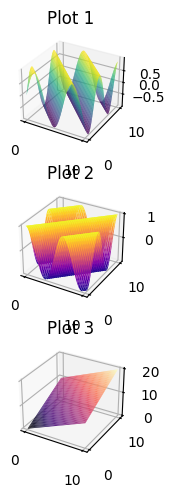

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create some sample data
x = np.linspace(0, 10, 100)
y = np.linspace(0, 10, 100)
x, y = np.meshgrid(x, y)
z1 = np.sin(x + y)
z2 = np.cos(x - y)
z3 = x + y

# Create a 3D stack of plots
fig = plt.figure()

# Plot 1
ax1 = fig.add_subplot(3, 1, 1, projection='3d')
ax1.plot_surface(x, y, z1, cmap='viridis')
ax1.set_title('Plot 1')

# Plot 2
ax2 = fig.add_subplot(3, 1, 2, projection='3d')
ax2.plot_surface(x, y, z2, cmap='plasma')
ax2.set_title('Plot 2')

# Plot 3
ax3 = fig.add_subplot(3, 1, 3, projection='3d')
ax3.plot_surface(x, y, z3, cmap='magma')
ax3.set_title('Plot 3')

plt.tight_layout()  # Adjust layout to prevent overlapping

plt.show()
